In [4]:
import os

# Go up two directories and into static/lung_data
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'static', 'lung_data'))

train_folder = os.path.join(base_dir, 'train')
test_folder = os.path.join(base_dir, 'test')
validate_folder = os.path.join(base_dir, 'valid')


In [5]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Set the image size for resizing
IMAGE_SIZE = (350, 350)

# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


# Define the batch size for training
batch_size = 8


# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Libraries Imported
Reading training images from: c:\Users\Atman Mehta\HealthMate\HealthMate\static\lung_data\train
Reading validation images from: c:\Users\Atman Mehta\HealthMate\HealthMate\static\lung_data\valid
Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [6]:
# Set up callbacks for learning rate reduction, early stopping, and model checkpointing
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)

In [7]:
# Define the number of output classes
OUTPUT_SIZE = 4

# Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350, 350,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 174, 174,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 174, 174,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 174, 174,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 172, 172,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 172, 172,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 172, 172,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 172, 172,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 172, 172,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 172, 172,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 172, 172,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 172, 172,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 86, 86,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 86, 86,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 86, 86,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 86, 86,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 86, 86,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 11, 11, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.3853 - loss: 1.3838
Epoch 1: val_loss improved from inf to 1.15978, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3871 - loss: 1.3810 - val_accuracy: 0.5063 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5138 - loss: 1.0903
Epoch 2: val_loss improved from 1.15978 to 1.02463, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5146 - loss: 1.0892 - val_accuracy: 0.5312 - val_loss: 1.0246 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5893 - loss: 0.9671
Epoch 3: val_loss improved from 1.02463 to 0.93662, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5892 - loss: 0.9660 - val_accuracy: 0.6000 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 4/50
 2/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2

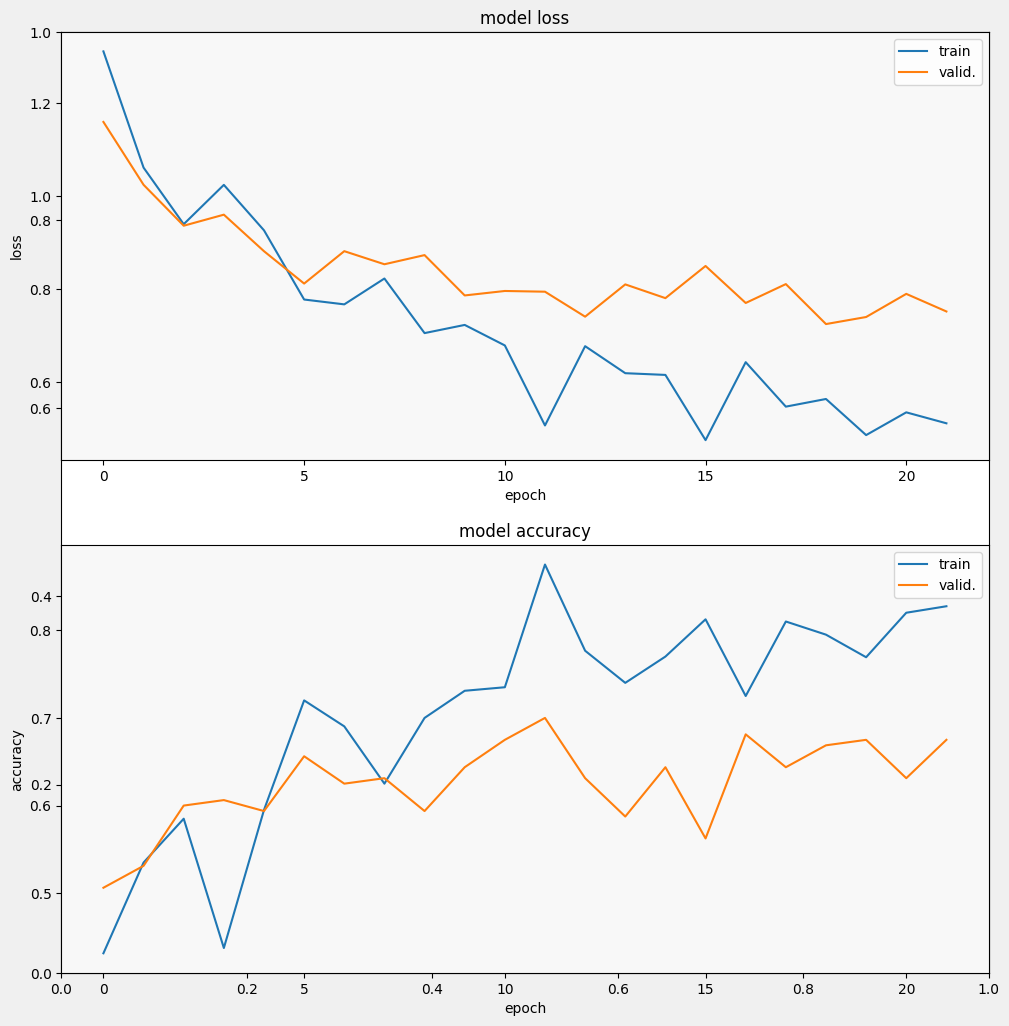

In [9]:
# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [10]:
# Save the trained model
model.save('models/trained_lung_cancer_model.h5')


In [11]:
import os
print(os.getcwd())


c:\Users\Atman Mehta\HealthMate\HealthMate\models\Lung-cancer-prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The image belongs to class: normal


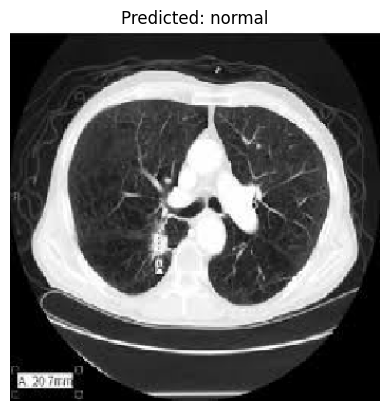

In [15]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Get base directory (where your script is running)
current_dir = os.getcwd()
while not os.path.isdir(os.path.join(current_dir, 'static')):
    current_dir = os.path.dirname(current_dir)

# Build the relative path to the image
img_path = os.path.join(
    current_dir, 'static', 'lung_data', 'train',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'sq2.png'
)

# Load, preprocess, and predict the class of an image
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


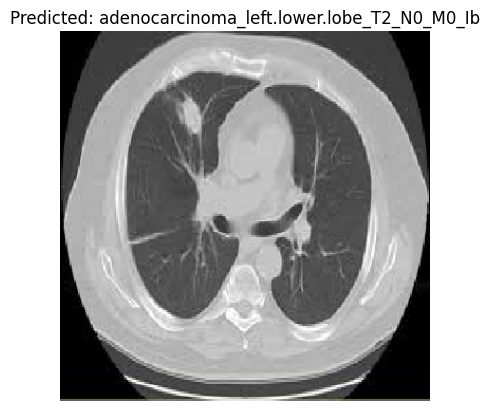

In [16]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Dynamically locate the 'static' folder
current_dir = os.getcwd()
while not os.path.isdir(os.path.join(current_dir, 'static')):
    current_dir = os.path.dirname(current_dir)

# Build the relative path to the image
img_path = os.path.join(
    current_dir, 'static', 'lung_data', 'train',
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'ad3.png'
)

# Load and preprocess
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print and display
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


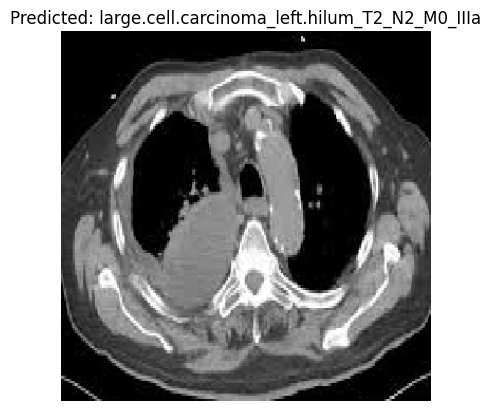

In [17]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Dynamically locate the 'static' folder
current_dir = os.getcwd()
while not os.path.isdir(os.path.join(current_dir, 'static')):
    current_dir = os.path.dirname(current_dir)

# Build the relative path to the image
img_path = os.path.join(
    current_dir, 'static', 'lung_data', 'train',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'l3.png'
)

# Load and preprocess the image
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
The image belongs to class: normal


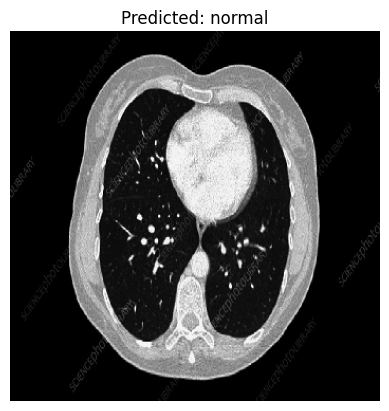

In [19]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Dynamically locate the 'static' folder
current_dir = os.getcwd()
while not os.path.isdir(os.path.join(current_dir, 'static')):
    current_dir = os.path.dirname(current_dir)

# Build the relative path to the image
img_path = os.path.join(
    current_dir, 'static', 'lung_data', 'train',
    'normal', 'n8.jpg'
)

# Load and preprocess the image
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
